## For문을 통해 수정한 코드

In [60]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm
from tools_ryu import mytool

In [61]:
d = pd.read_pickle("ddata.pickle")

In [62]:
vol = pd.pivot_table(data=d,
                     values="tvol", 
                     index=d.index, 
                     columns="permno")

mktcap = pd.pivot_table(data=d,
                        values="mcap", 
                        index=d.index, 
                        columns="permno")

price = pd.pivot_table(data=d,
                        values="prc", 
                        index=d.index, 
                        columns="permno")

#vol_mask = (vol.rolling(window=30).mean() > 1_000_000).replace({True:1,
#                                                                 False: np.nan})

In [63]:
daily_rtn = price.pct_change(fill_method=None)
#mktcap_mask = (mktcap.rolling(window=30).mean() > 1_000_000) \
#                     .replace({True:1,
#                               False:np.nan})
#
#mktcap_screened = (mktcap * mktcap_mask * vol_mask)

In [64]:
# 시작일 찾기
#start_idx = (mktcap_screened.isna().sum(1) < 222).replace(False,np.nan).dropna().index[0]

# weight 계산
#weight = mktcap_screened.loc[start_idx:].apply(lambda x: x / np.nansum(x), axis=1)
weight = mktcap.loc[:].apply(lambda x: x / np.nansum(x), axis=1)

# 마켓 인덱스 만들기
mkt_index = (daily_rtn*weight.shift(1)).sum(1)

In [65]:
weight.loc[:].sum(1)

date
2013-05-06    1.0
2013-05-07    1.0
2013-05-08    1.0
2013-05-09    1.0
2013-05-10    1.0
             ... 
2023-04-03    1.0
2023-04-04    1.0
2023-04-05    1.0
2023-04-06    1.0
2023-04-07    1.0
Length: 3624, dtype: float64

In [7]:
#start_idx

Timestamp('2013-12-27 00:00:00')

Cross-Sectional-Momentum : Weekly Rebalancing

In [66]:
weekly_mktcap = mktcap.loc[:].resample("W").last()
weekly_rtn = price.loc[:].pct_change(7,fill_method=None) \
                  .resample("W").last()
#weekly_vol_mask = vol_mask.loc[start_idx:].resample("W").last()

In [67]:
# Momentum 그룹을 구하기 위해서 필요함
weekly_rtn_pp = weekly_rtn * np.sign(weekly_mktcap) #* weekly_vol_mask

In [68]:
# 언제부터 시작하는 지 찾자 (최소 80개의 코인이 필요)
cnt = weekly_rtn_pp.count(1)
more100 = cnt.loc[cnt > 79] # 여기서 start date가 나온다
start = more100.index[0]
more100

date
2019-07-07     80
2019-07-14     81
2019-07-21     81
2019-07-28     83
2019-08-04     85
             ... 
2023-03-12    202
2023-03-19    202
2023-03-26    198
2023-04-02    199
2023-04-09    199
Freq: W-SUN, Length: 197, dtype: int64

In [69]:
weekly_rtn_sample_pp = weekly_rtn_pp.loc[start:]
weekly_mktcap_sample = weekly_mktcap.loc[start:]

In [71]:
# rank를 계산해줍니다
rank = weekly_rtn_sample_pp.rank(axis=1, method="first")

# rank가 존재하는 코인의 수를 구합니다
coin_count = rank.count(axis=1)

# 그룹별로 동일한 코인 수를 포함하기 위해 각 그룹의 rank thresh를 생성해줍니다
rank_thresh = coin_count.apply(lambda x: [i for i in range(0,x, x//4)])

t1 = rank_thresh.apply(lambda x: x[1])
t2 = rank_thresh.apply(lambda x: x[2])
t3 = rank_thresh.apply(lambda x: x[3])

rank_thresh

date
2019-07-07           [0, 20, 40, 60]
2019-07-14       [0, 20, 40, 60, 80]
2019-07-21       [0, 20, 40, 60, 80]
2019-07-28       [0, 20, 40, 60, 80]
2019-08-04       [0, 21, 42, 63, 84]
                       ...          
2023-03-12    [0, 50, 100, 150, 200]
2023-03-19    [0, 50, 100, 150, 200]
2023-03-26     [0, 49, 98, 147, 196]
2023-04-02     [0, 49, 98, 147, 196]
2023-04-09     [0, 49, 98, 147, 196]
Freq: W-SUN, Length: 197, dtype: object

In [72]:
g1_mask = rank.apply(lambda x: x <= t1, axis=0) \
              .replace({True:1, False:np.nan})
g2_mask = rank.apply(lambda x: (t1 < x)&(x <= t2), axis=0) \
              .replace({True:1, False:np.nan})
g3_mask = rank.apply(lambda x: (t2 < x)&(x <= t3), axis=0) \
              .replace({True:1, False:np.nan})
g4_mask = rank.apply(lambda x: (t3 < x), axis=0) \
              .replace({True:1, False:np.nan})           

In [73]:
# 각 그룹별 weight를 생성
weight_g1 = (g1_mask * weekly_mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)
weight_g2 = (g2_mask * weekly_mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)
weight_g3 = (g3_mask * weekly_mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)
weight_g4 = (g4_mask * weekly_mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)

# 여기까지가 t기에 weight를 구하는 과정까지다 
each_weight = {"Q1":weight_g1,
               "Q2":weight_g2,
               "Q3":weight_g3,
               "Q4":weight_g4
}

In [80]:
final_value = {}

for key, weight_matrix in tqdm(each_weight.items(),desc="Processing dictionary"):
    pf_value = 1
    strategy_rtn = {}

    for t in weight_matrix.index:
        dollar_value = weight_matrix.loc[t] * pf_value    # 포트폴리오가 담을 각 코인의 달러가치

        # 여기까지가 t기 close에 momentum을 계산하고, 몇 개의 코인을 살지 결정한 것이다
        ## t+1기 부터 t+7기 close까지 수익을 계산해야 한다
        t_1, t_7 = t + pd.Timedelta(days=1), t + pd.Timedelta(days=7)
        for date in pd.date_range(t_1, t_7):
            if date > weight_matrix.index[-1] - pd.Timedelta(days=2): # 우리가 가진 데이터의 기간 밖이면 break
                break
            dollar_value = dollar_value * (1+daily_rtn.loc[date]) #코인의 dollar value 변화를 추적
            pf_value = dollar_value.sum()
            strategy_rtn[str(date.strftime("%Y-%m-%d"))] = pf_value
    # 저장
    pf_save = pd.Series(strategy_rtn)
    pf_save.index = pd.to_datetime(pf_save.index)
    pf_save[pf_save.index[0] - pd.Timedelta(days=1)] = 1 # 투자 시작일 포트폴리오 가치를 1로 셋팅
    final_value[key] = pf_save.sort_index().pct_change().fillna(0)

Processing dictionary: 100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


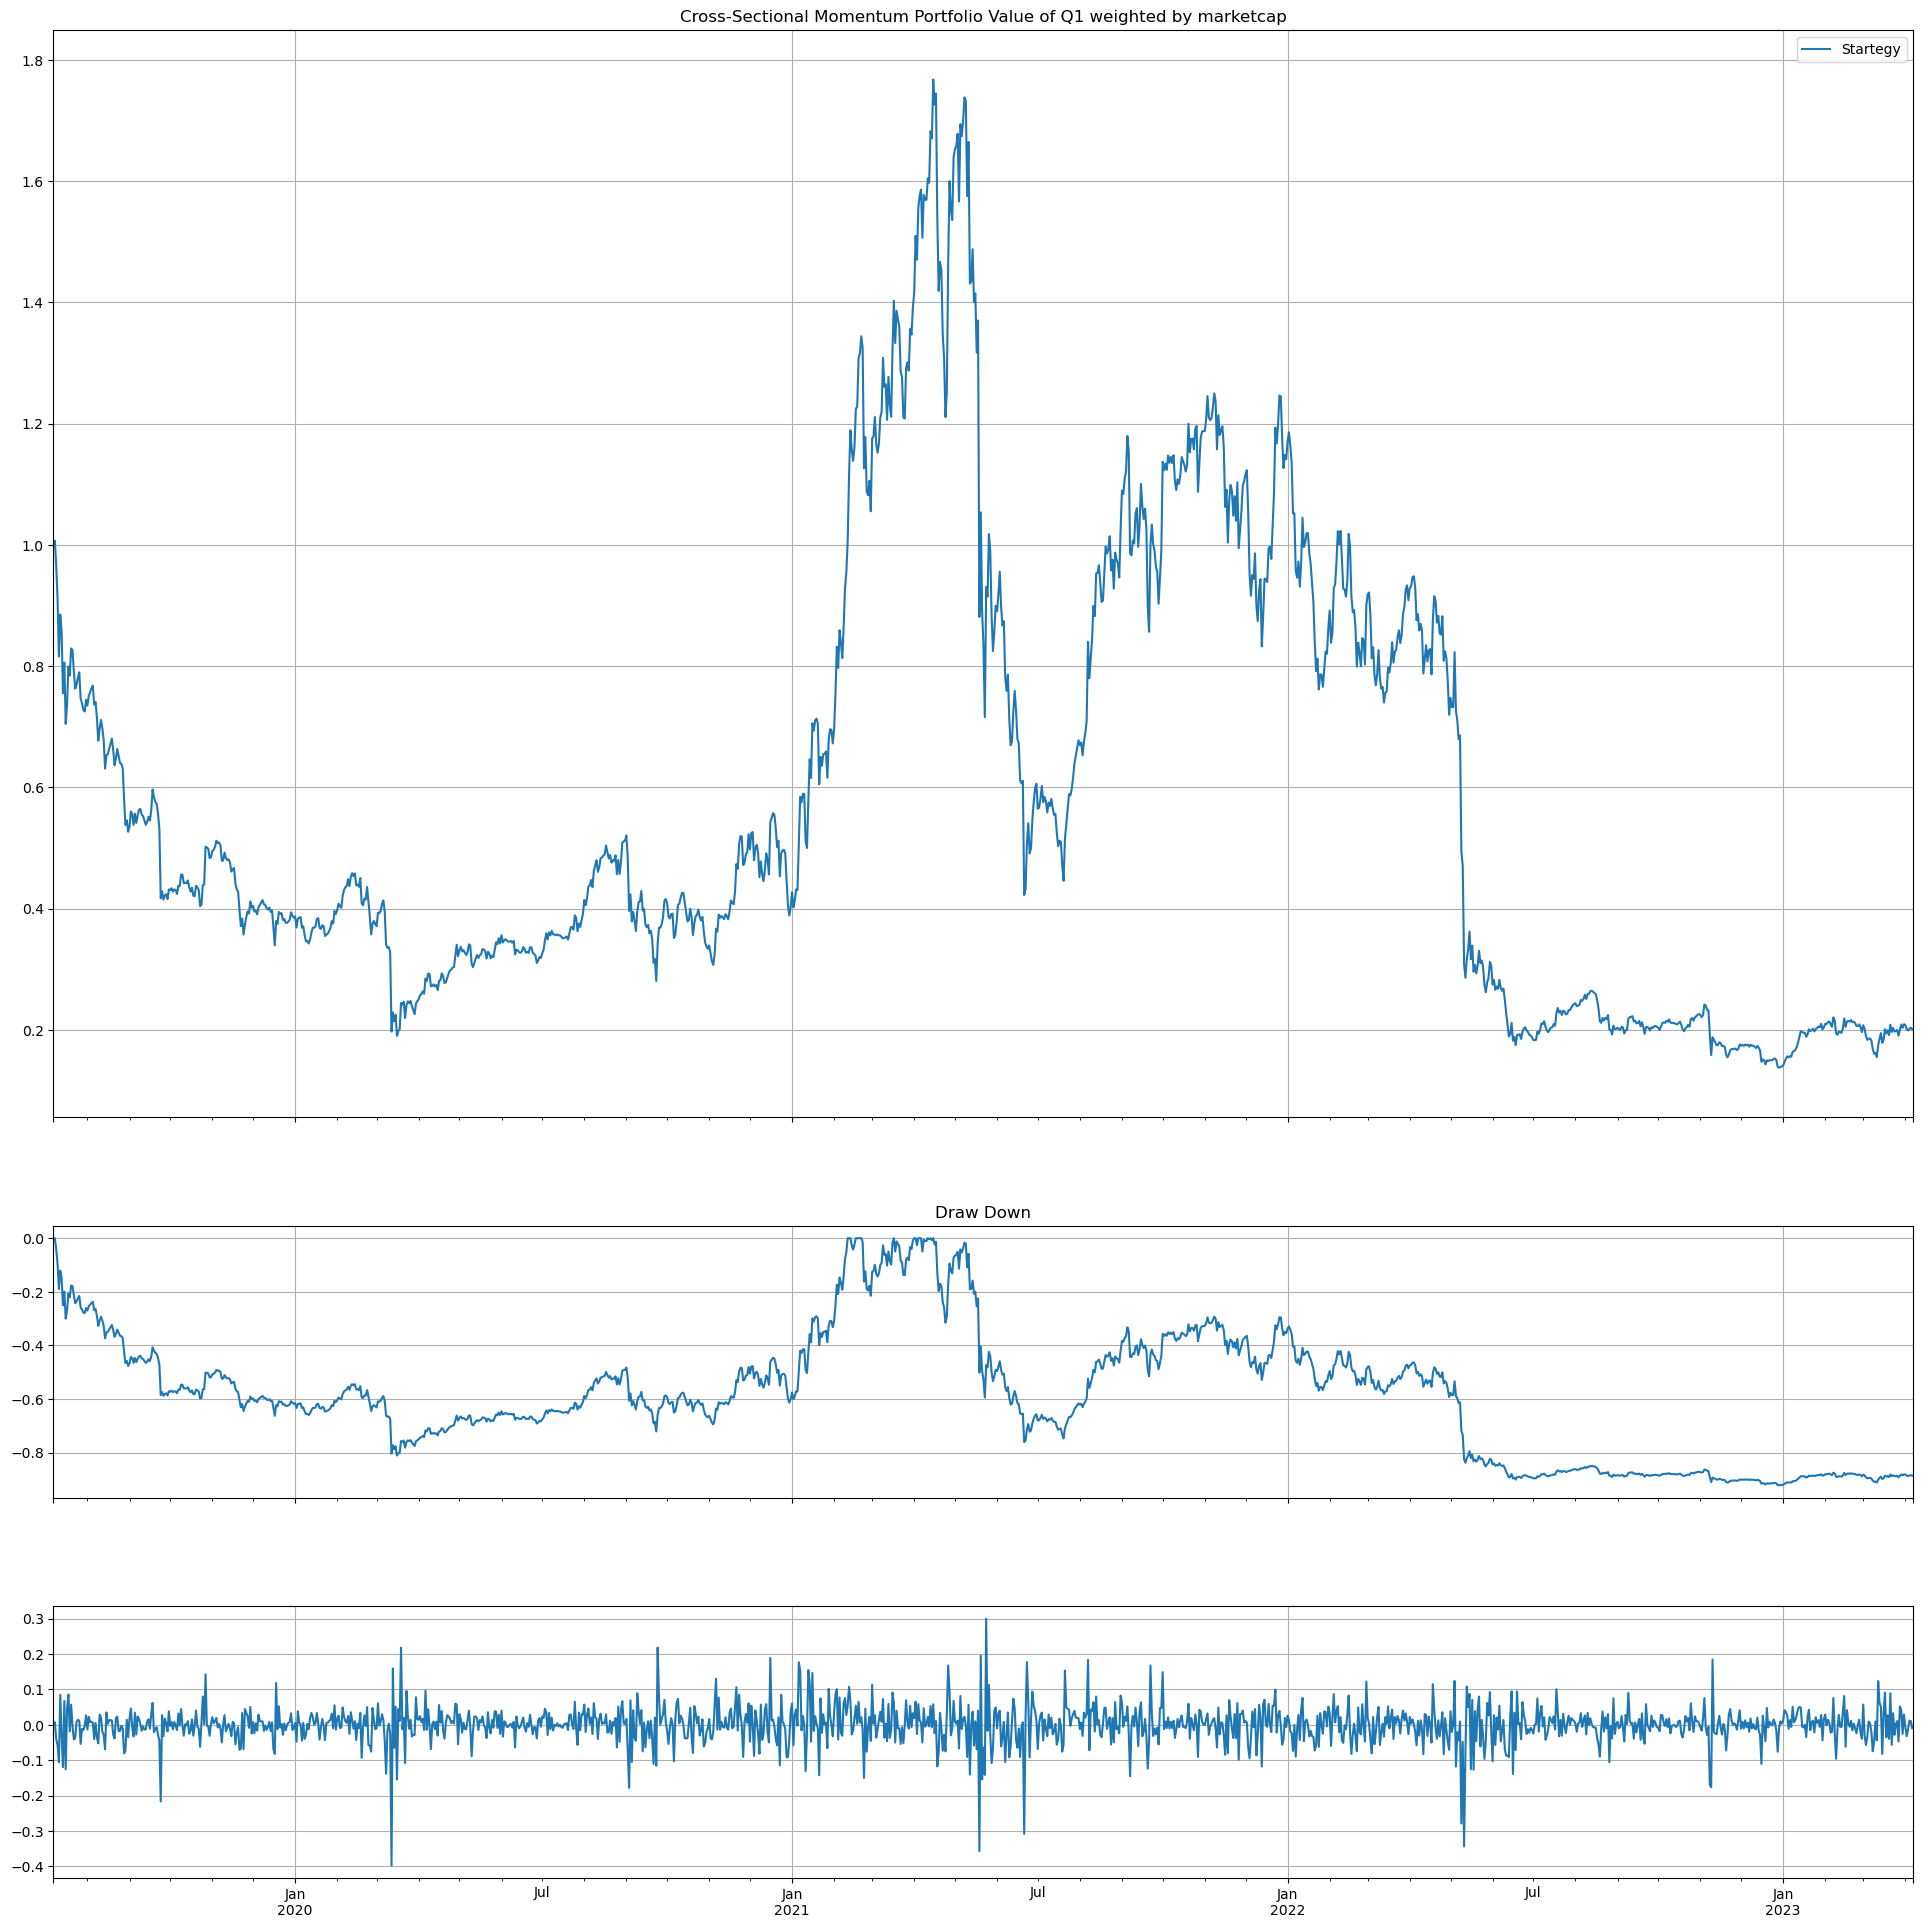

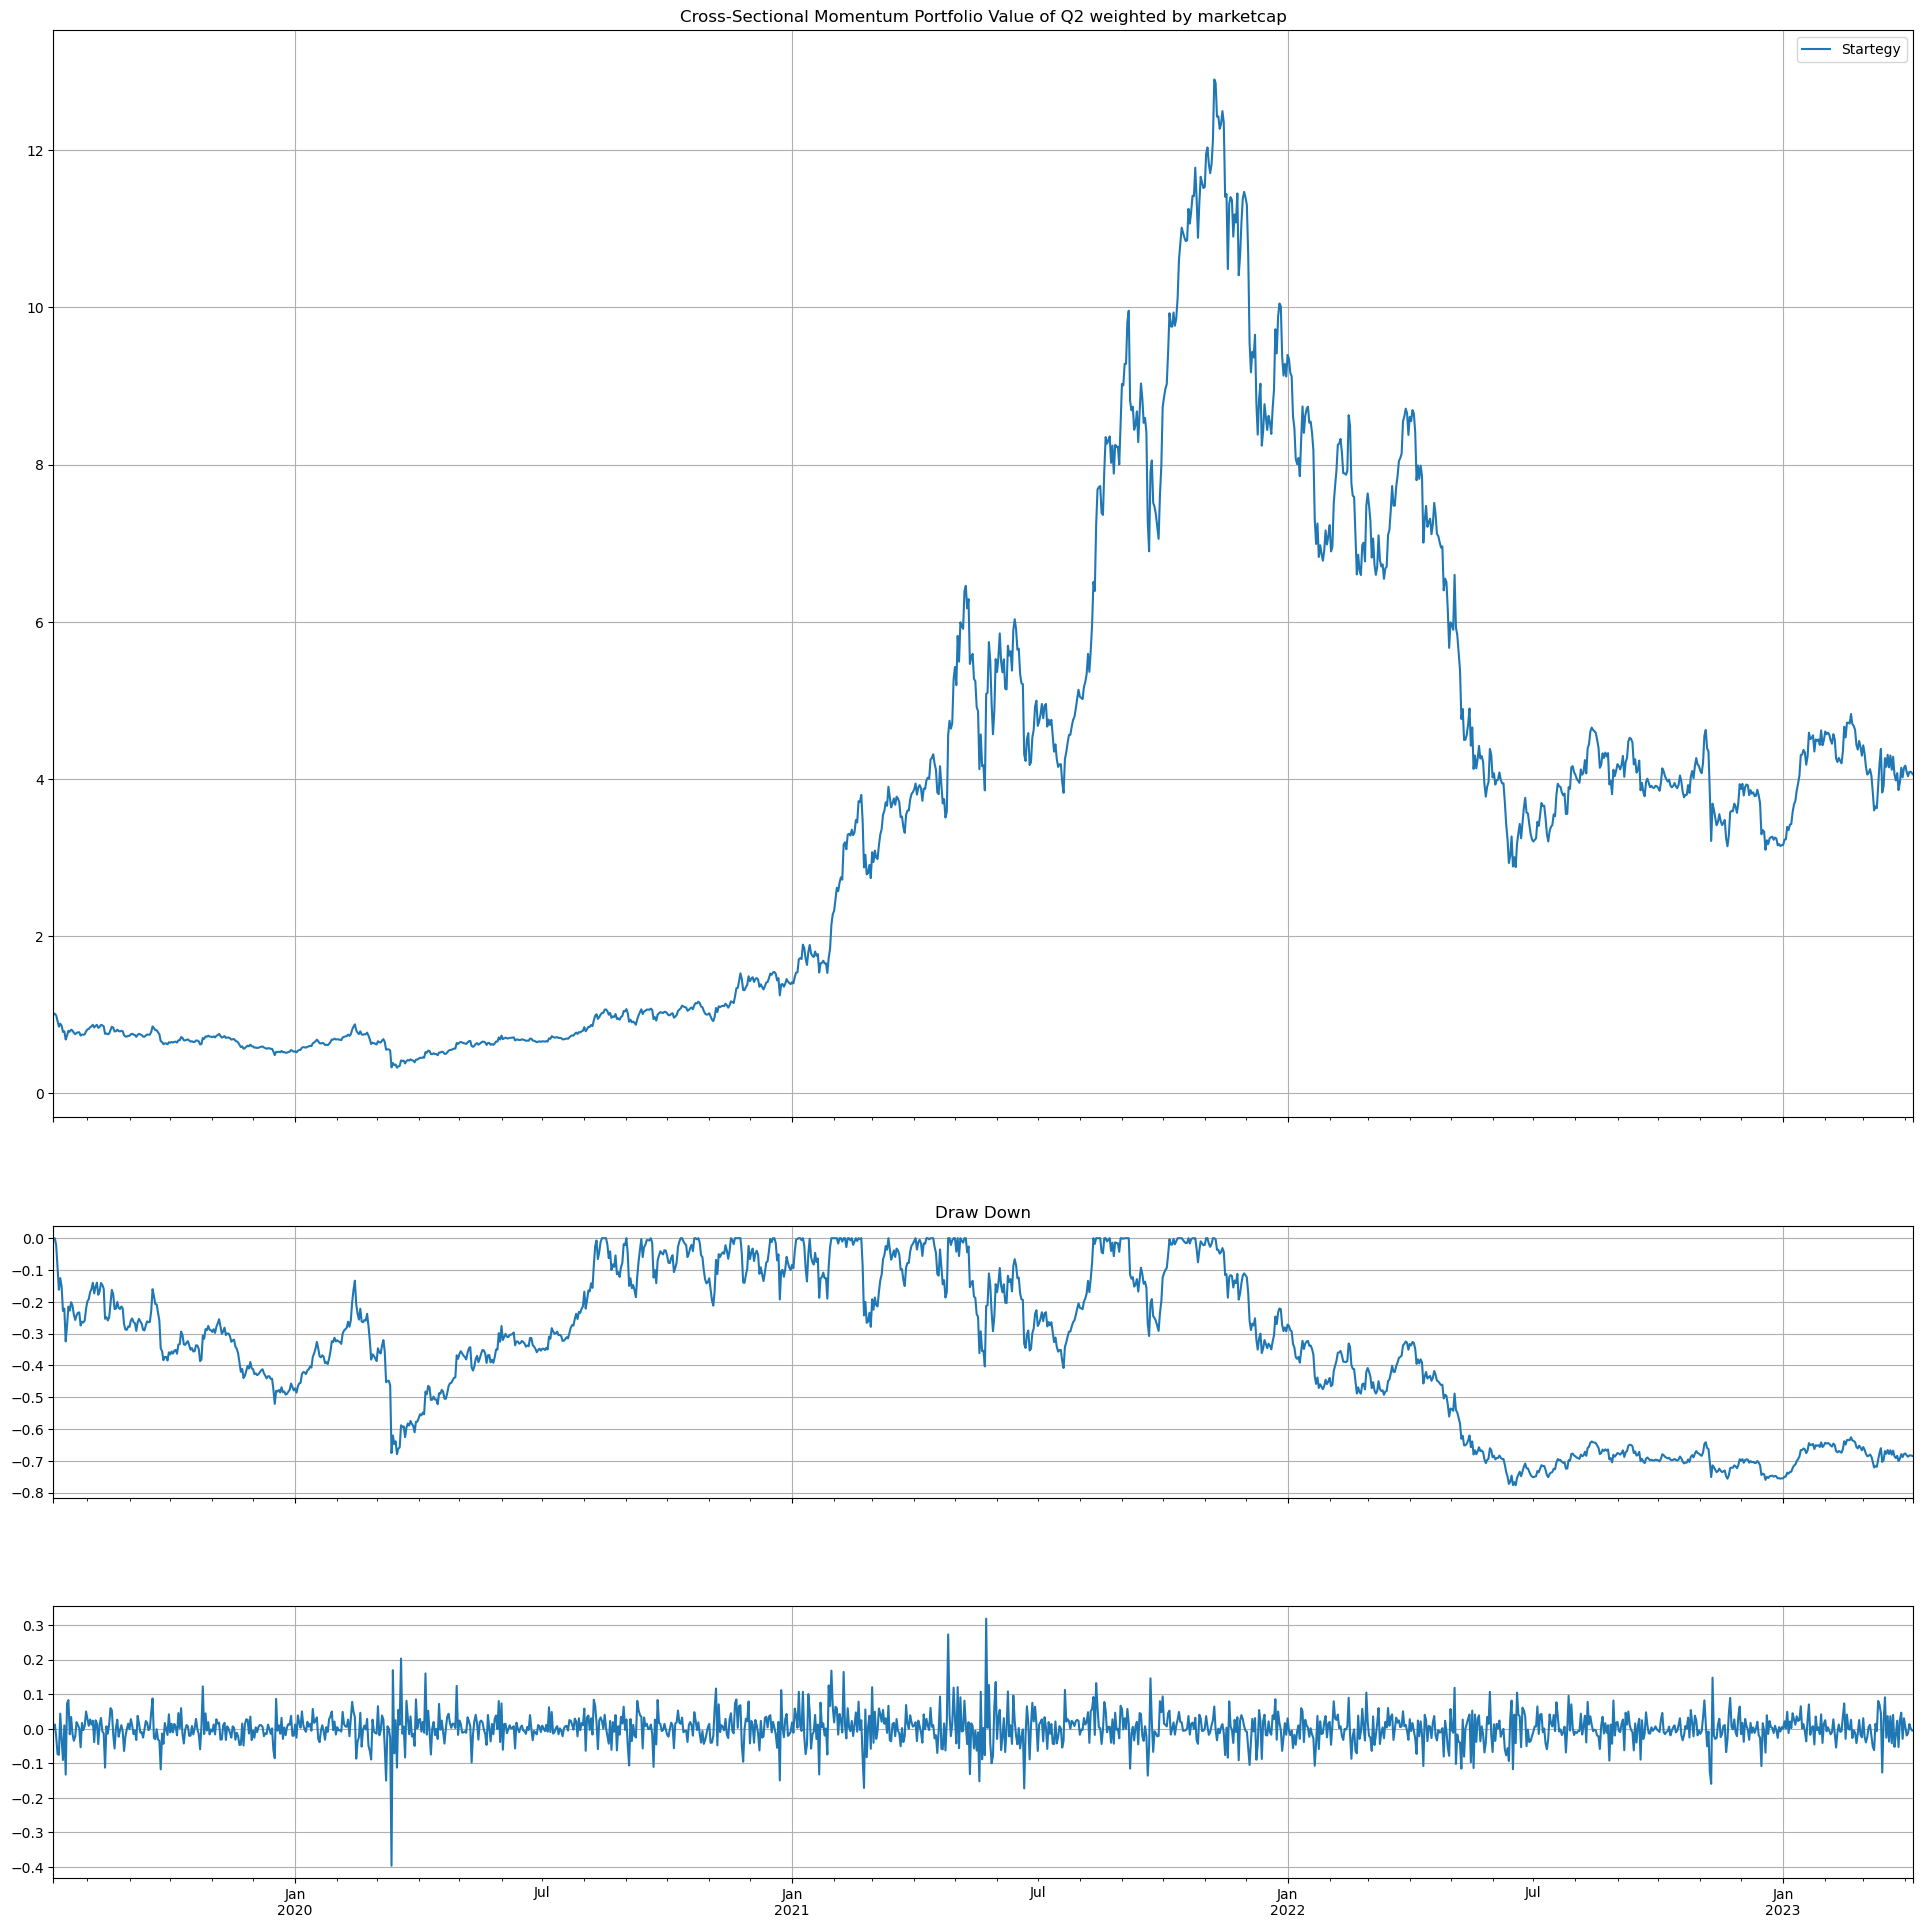

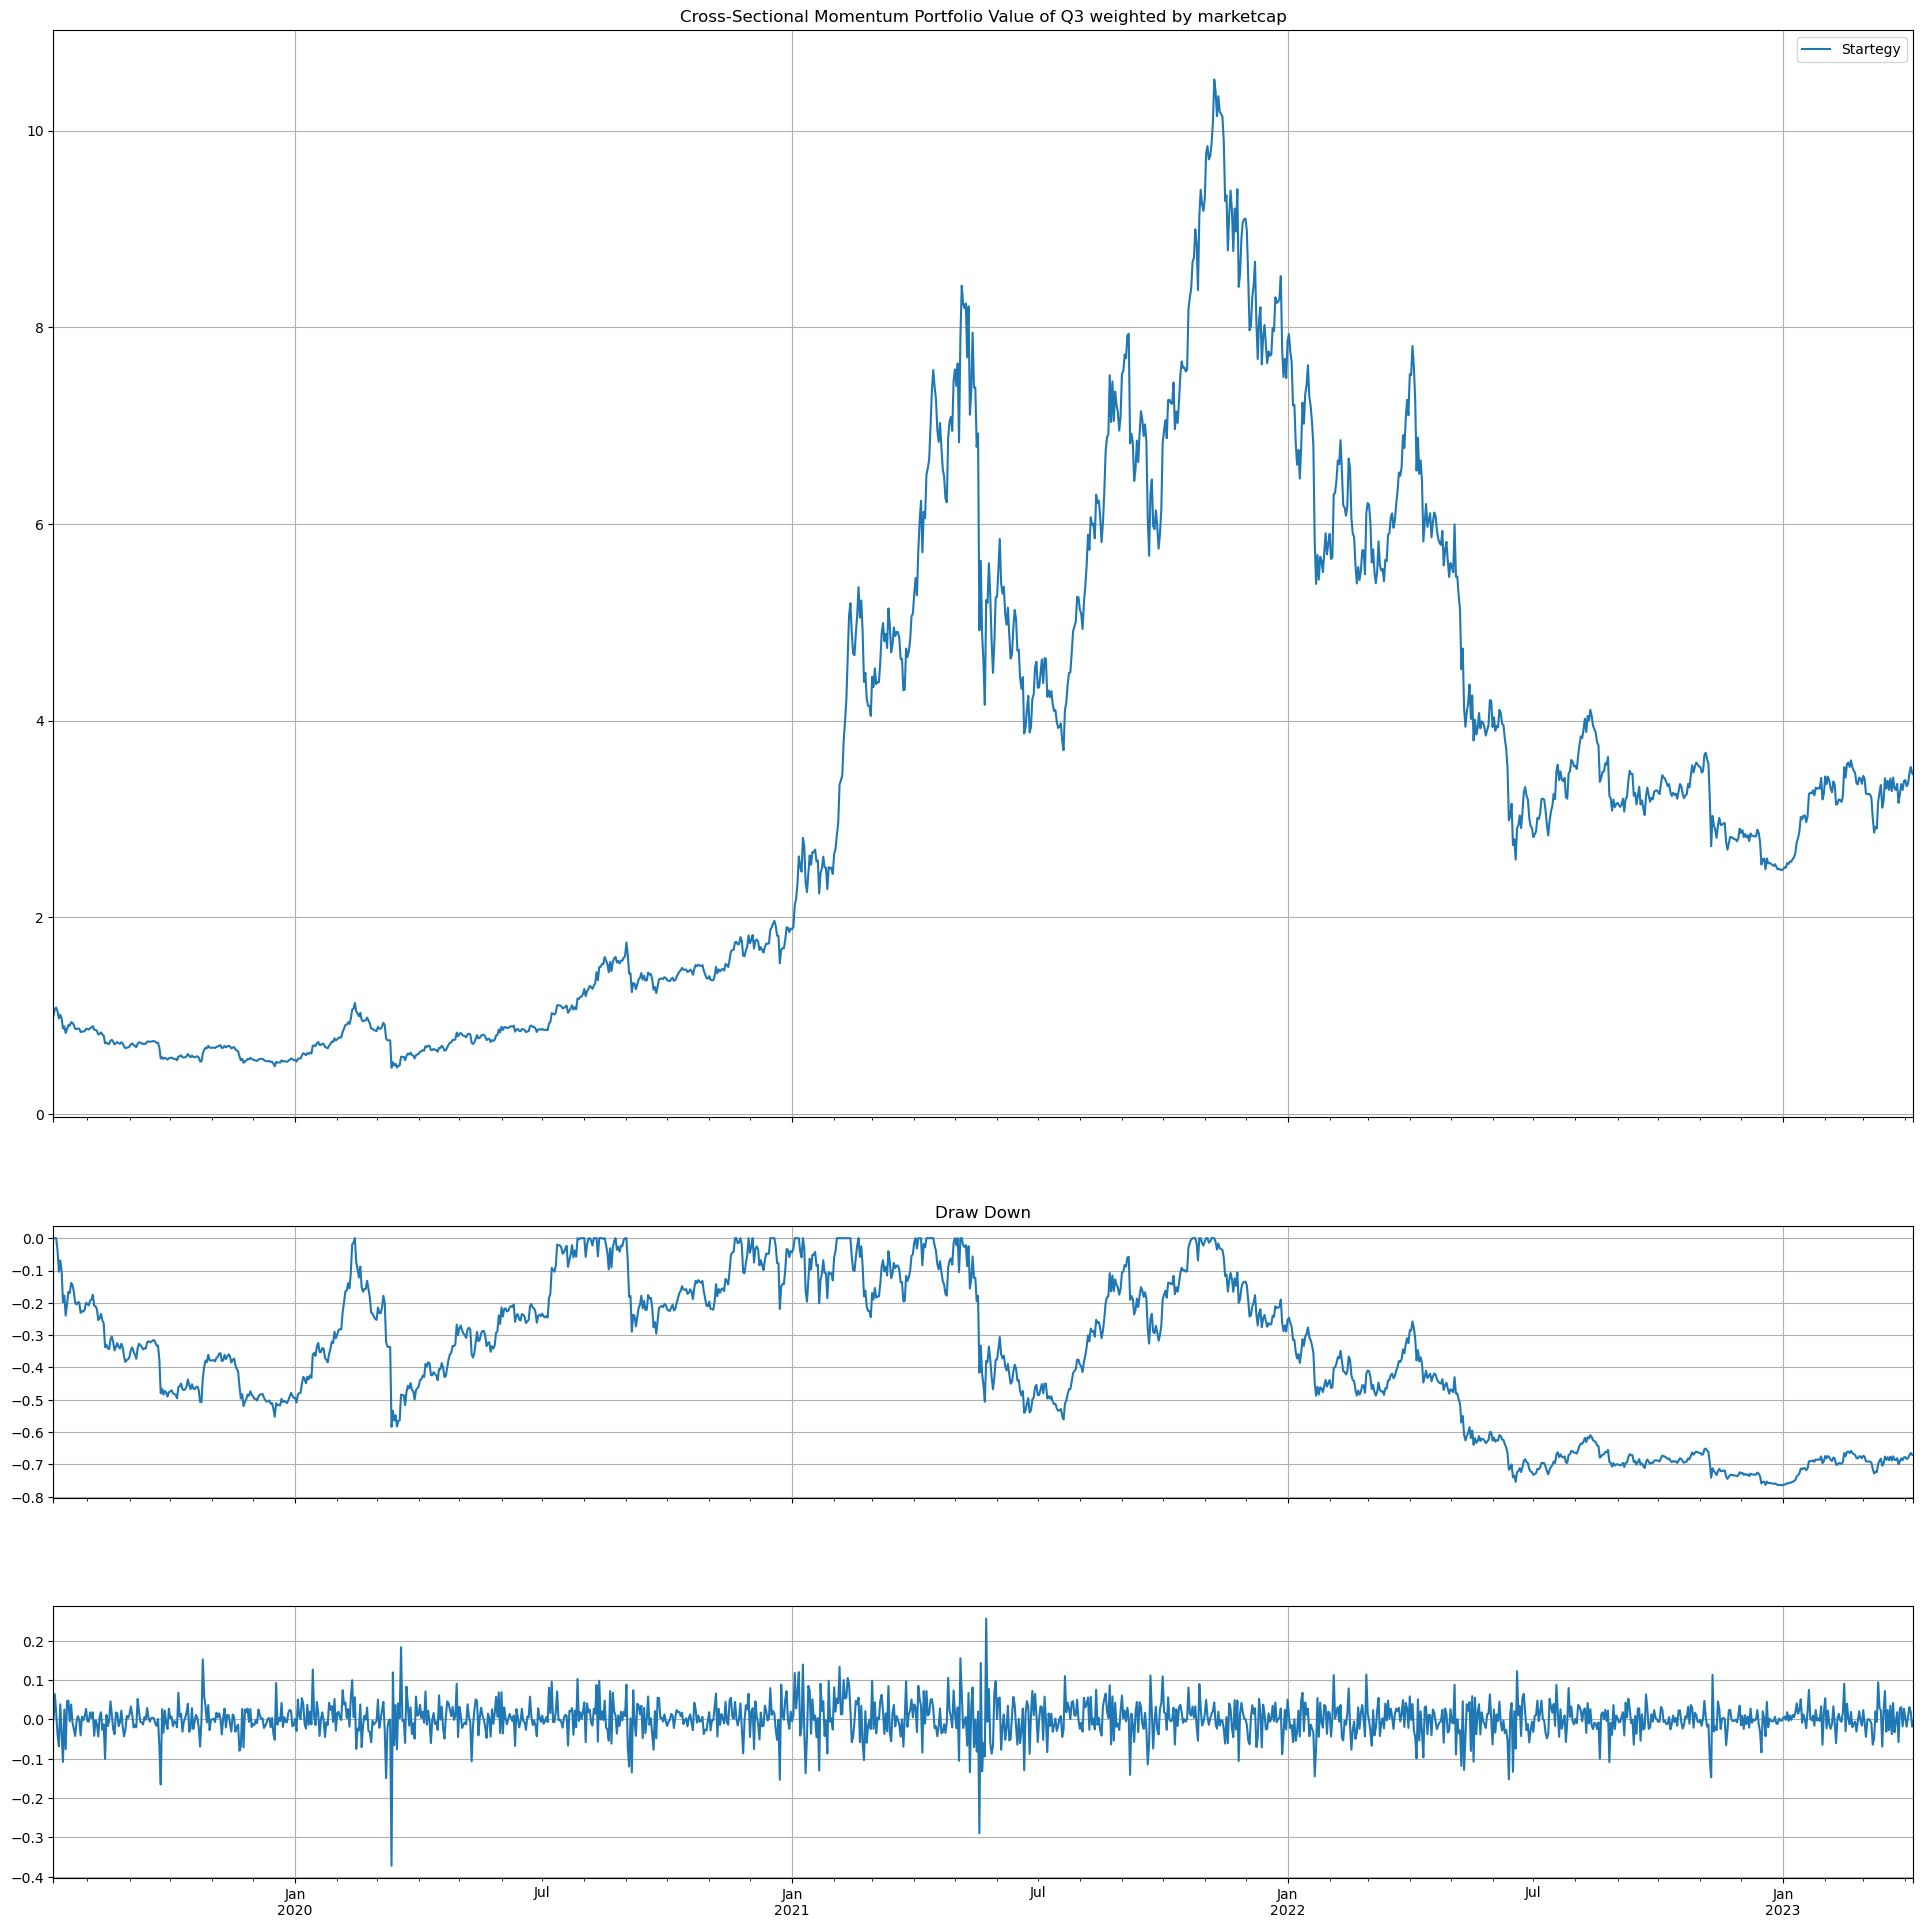

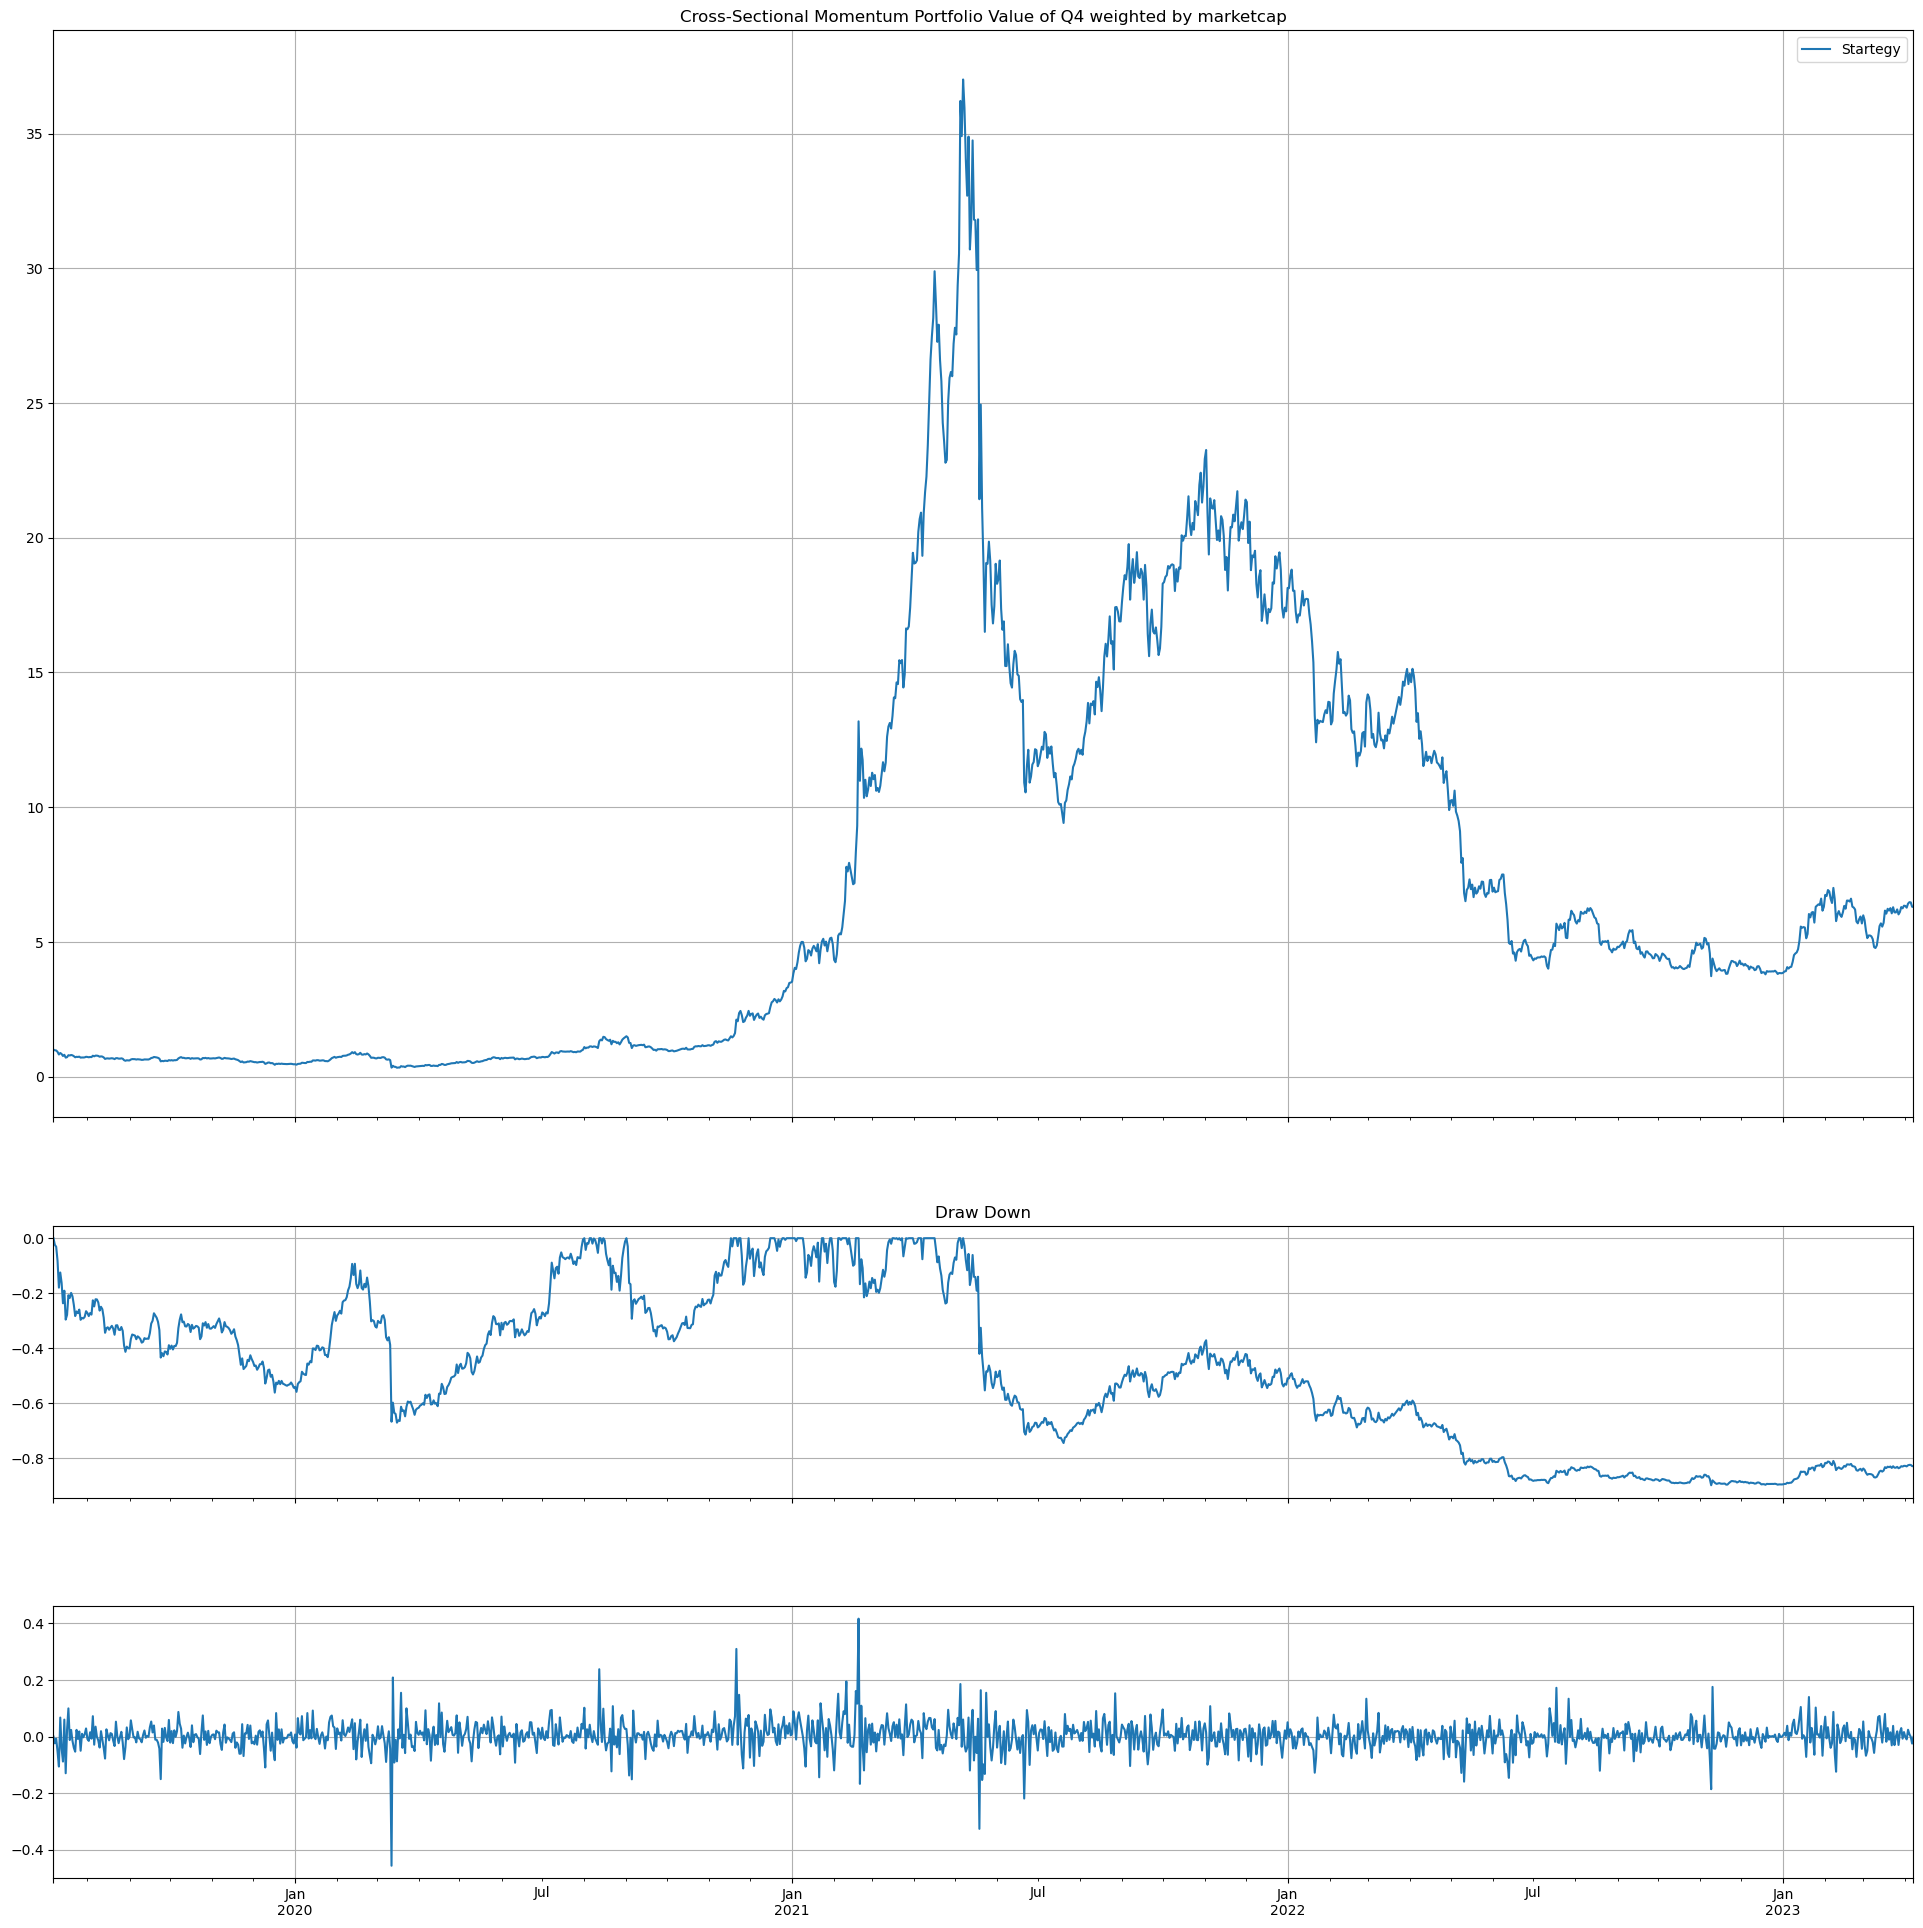

In [81]:
mytool.draw_return_result(final_value)

In [82]:
mytool.print_statistics(final_value)

,0,1,2,3
CAGR,-34.9298%,44.7144%,36.808099999999996%,64.3148%
Mean,0.087625,0.751325,0.692221,0.965053
STD,0.993234,0.864293,0.839702,0.963616
Sharpe,0.088222,0.869294,0.824365,1.001491


In [83]:
# 롱숏추가
ls = final_value["Q4"] - final_value["Q1"]

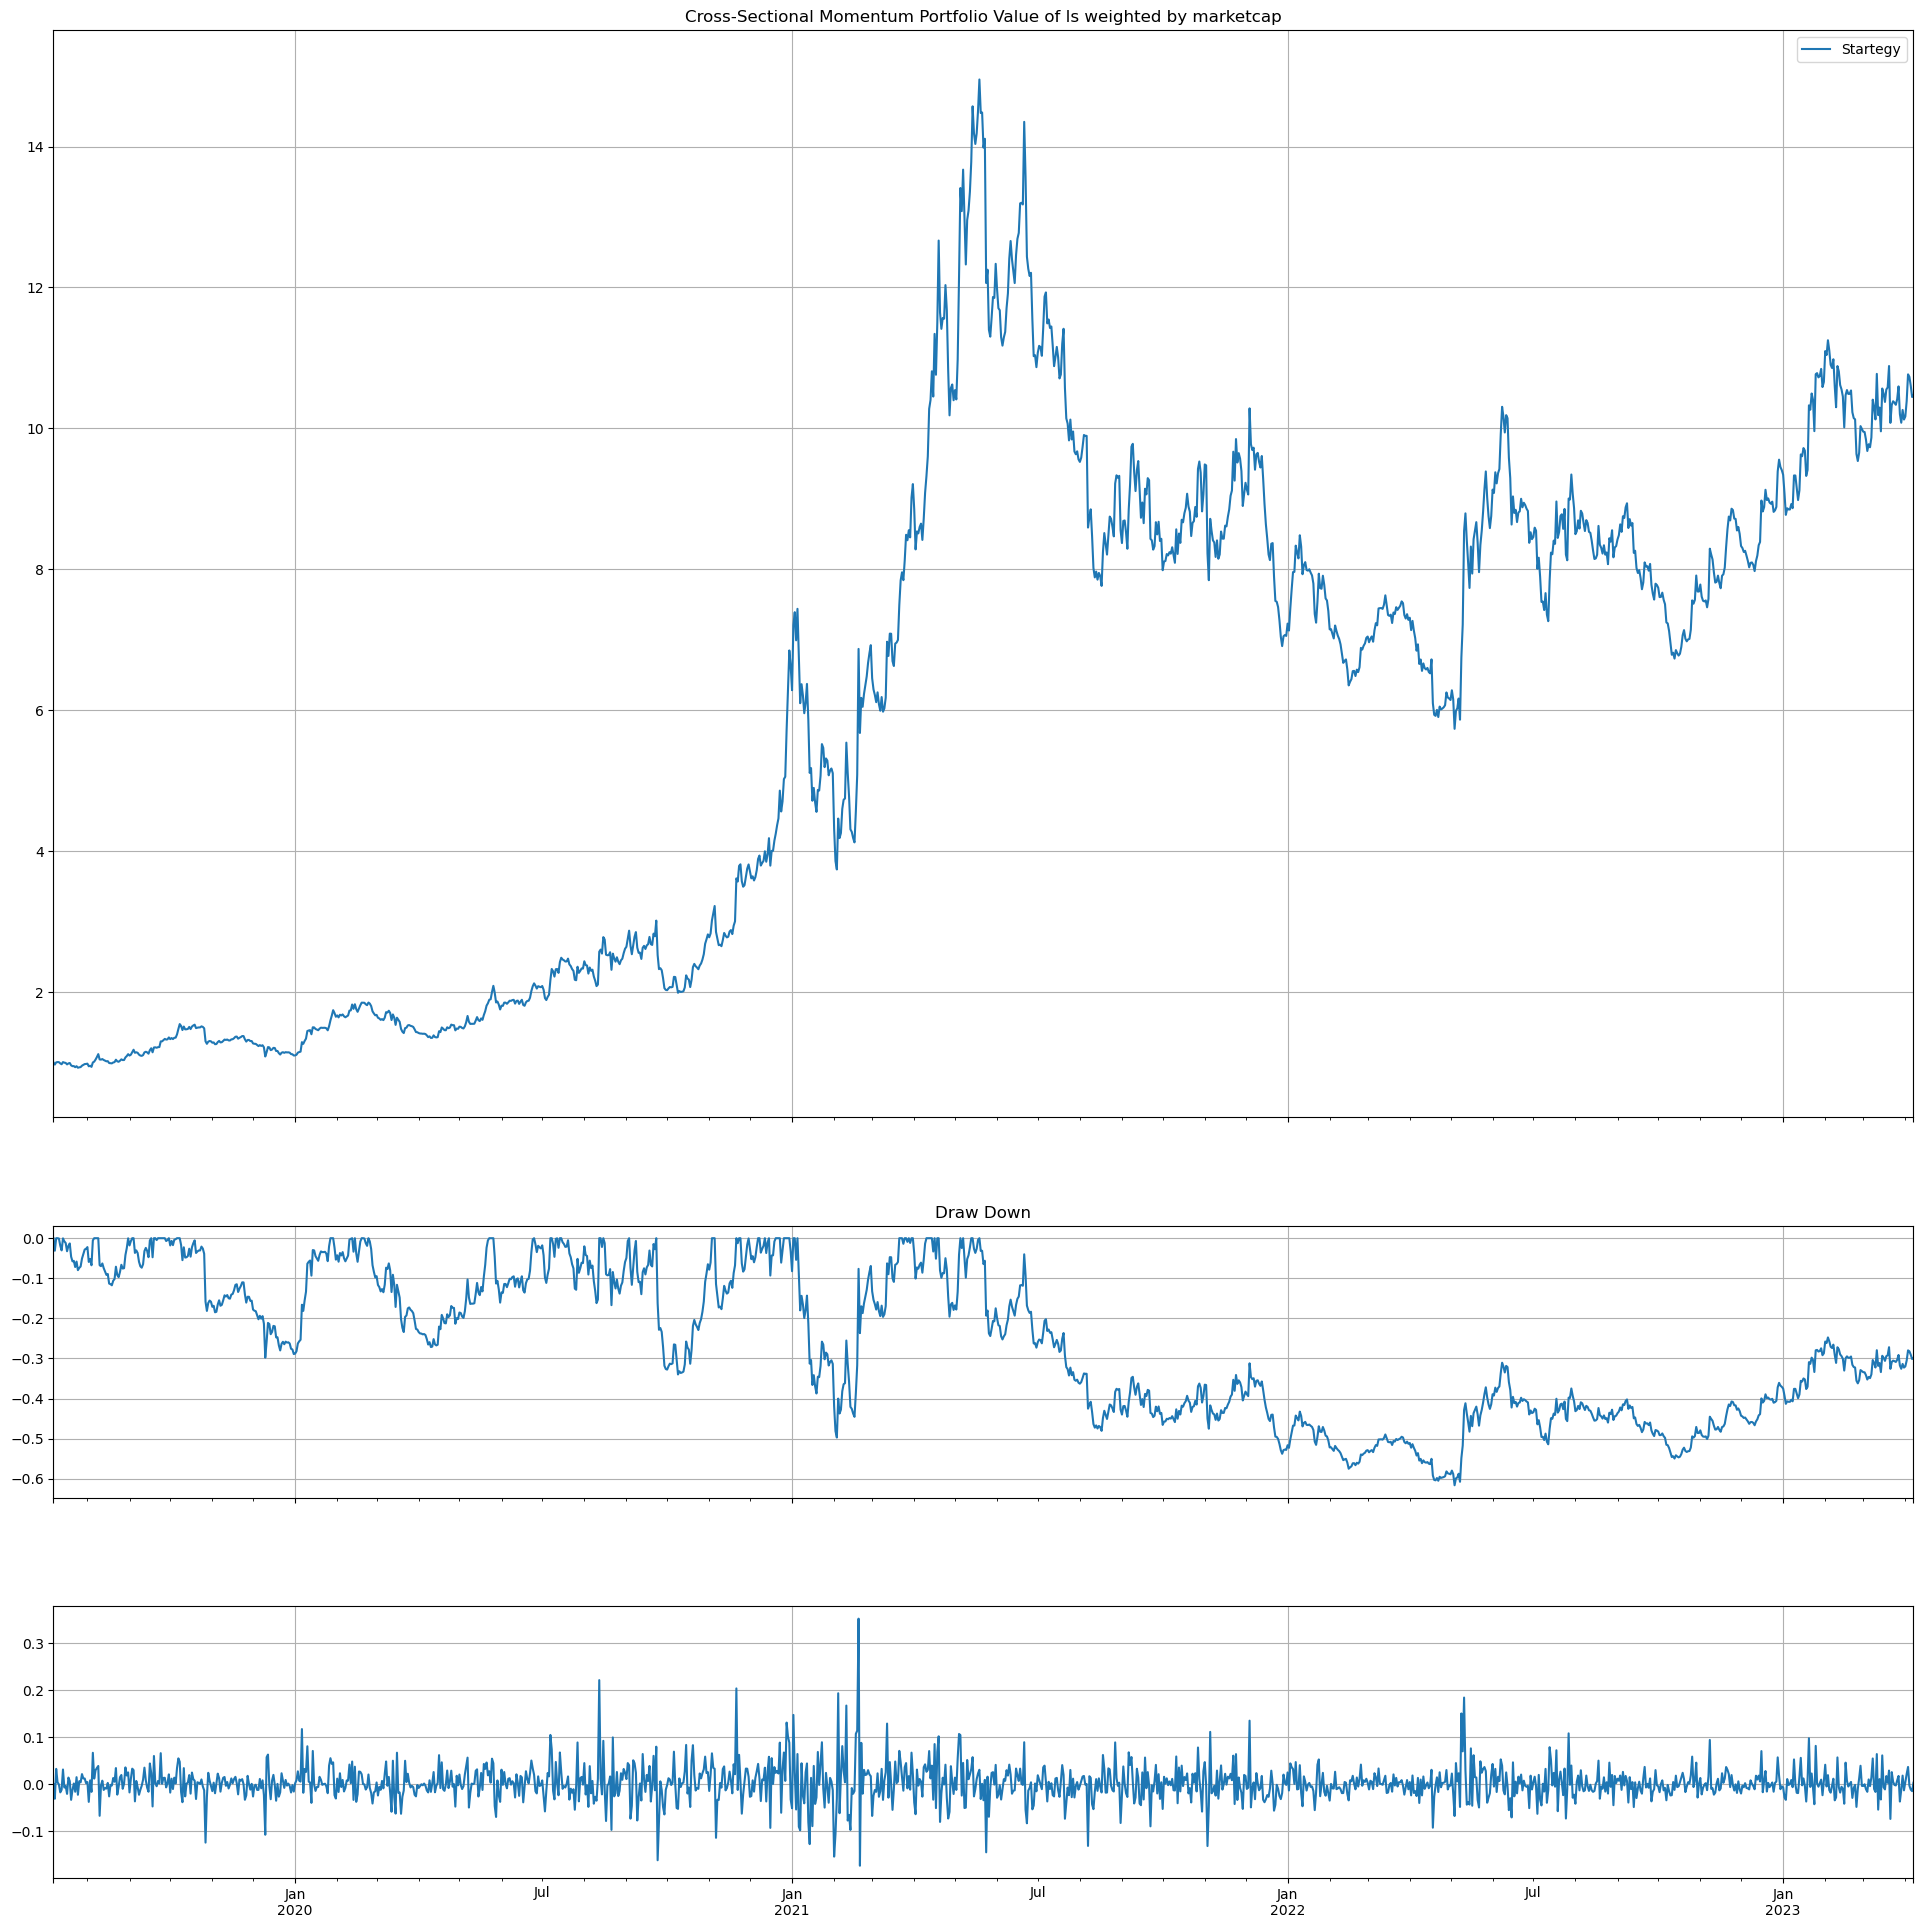

In [85]:
mytool.draw_return_result({"ls":ls})

In [86]:
mytool.print_statistics({"ls":ls})

,0
CAGR,88.5617%
Mean,0.877428
STD,0.715967
Sharpe,1.225515
